In [22]:
import pandas as pd
import numpy as np

# 1. יצירת דאטה מדומה (Simulation)
# נדמה 20 מטופלים עם נתונים אקראיים בטווחים הגיוניים
np.random.seed(42) # כדי שהתוצאות יהיו עקביות
# שינוי מספר המטופלים מ-20 ל-1000
n_patients = 1000  # <--- השינוי כאן

data = {
    'Patient_ID': range(1, n_patients + 1),
    'Age': np.random.randint(60, 90, n_patients),
    'Gender': np.random.choice(['M', 'F'], n_patients),
    # כוח אחיזה בק"ג (טווח: 10-50)
    'Grip_Strength_KG': np.random.uniform(10, 50, n_patients).round(1),
    # אינדקס מסת שריר (טווח: 5.0-10.0)
    'SMI': np.random.uniform(5.0, 10.0, n_patients).round(2),
    # מהירות הליכה במטר לשנייה (טווח: 0.4-1.5)
    'Gait_Speed_ms': np.random.uniform(0.4, 1.5, n_patients).round(2)
}

df = pd.DataFrame(data)

# 2. פונקציית הליבה לזיהוי סרקופניה (הלוגיקה הביולוגית)
# הערה: הספים נלקחו מהנחיות כלליות (EWGSOP2) לצורך הדגמה
def analyze_sarcopenia_risk(row):
    risk_score = 0
    reasons = []

    # ספים לגברים (M) ולנשים (F)
    thresholds = {
        'M': {'grip': 27, 'smi': 7.0},
        'F': {'grip': 16, 'smi': 5.5}
    }
    
    t = thresholds[row['Gender']]

    # קריטריון 1: כוח שריר ירוד (Grip Strength)
    if row['Grip_Strength_KG'] < t['grip']:
        risk_score += 1
        reasons.append('Low Grip Strength')

    # קריטריון 2: מסת שריר נמוכה (SMI)
    if row['SMI'] < t['smi']:
        risk_score += 1
        reasons.append('Low Muscle Mass')

    # קריטריון 3: ביצועים פיזיים ירודים (Gait Speed) - זהה לשני המינים
    if row['Gait_Speed_ms'] <= 0.8:
        risk_score += 1
        reasons.append('Slow Gait Speed')

    # החלטה סופית
    if risk_score >= 2:
        return pd.Series(['High Risk', ', '.join(reasons)])
    elif risk_score == 1:
        return pd.Series(['Moderate Risk', reasons[0]])
    else:
        return pd.Series(['Low Risk', '-'])

# 3. הרצת האנליזה על הדאטה
df[['Diagnosis', 'Details']] = df.apply(analyze_sarcopenia_risk, axis=1)

# הצגת התוצאות - רק אלו שבסיכון
print("--- Sarcopenia Analysis Results ---")
high_risk_patients = df[df['Diagnosis'] == 'High Risk']
print(high_risk_patients[['Patient_ID', 'Gender', 'Age', 'Diagnosis', 'Details']])

--- Sarcopenia Analysis Results ---
     Patient_ID Gender  Age  Diagnosis  \
1             2      M   79  High Risk   
5             6      M   67  High Risk   
10           11      F   78  High Risk   
12           13      M   70  High Risk   
23           24      F   83  High Risk   
..          ...    ...  ...        ...   
981         982      M   60  High Risk   
986         987      M   87  High Risk   
988         989      M   64  High Risk   
993         994      M   82  High Risk   
997         998      M   69  High Risk   

                                               Details  
1    Low Grip Strength, Low Muscle Mass, Slow Gait ...  
5                   Low Grip Strength, Slow Gait Speed  
10                  Low Grip Strength, Slow Gait Speed  
12   Low Grip Strength, Low Muscle Mass, Slow Gait ...  
23                    Low Muscle Mass, Slow Gait Speed  
..                                                 ...  
981  Low Grip Strength, Low Muscle Mass, Slow Gait ...  
986


--- Graph saved as 'sarcopenia_analysis.png' ---


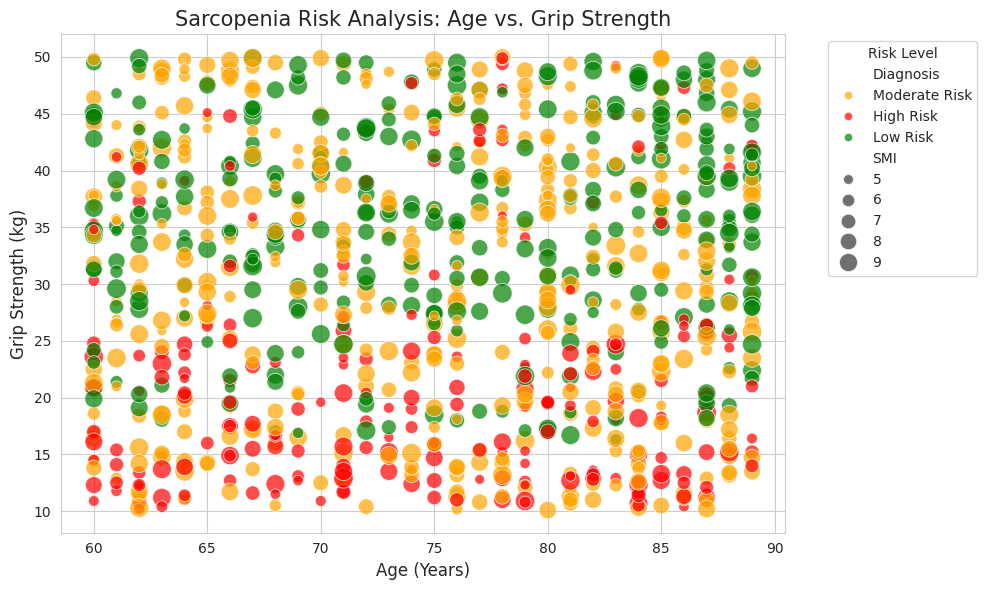

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(df):
    plt.figure(figsize=(10, 6))
    
    # נגדיר סגנון גרפי נקי
    sns.set_style("whitegrid")
    
    # יצירת Scatter Plot
    # ציר X: גיל
    # ציר Y: כוח אחיזה
    # צבע (Hue): לפי רמת הסיכון (הדיאגנוזה)
    # גודל הנקודה (Size): לפי מסת השריר (SMI)
    sns.scatterplot(
        data=df, 
        x='Age', 
        y='Grip_Strength_KG', 
        hue='Diagnosis', 
        palette={'High Risk': 'red', 'Moderate Risk': 'orange', 'Low Risk': 'green'},
        size='SMI',
        sizes=(50, 200),
        alpha=0.7
    )

    plt.title('Sarcopenia Risk Analysis: Age vs. Grip Strength', fontsize=15)
    plt.xlabel('Age (Years)', fontsize=12)
    plt.ylabel('Grip Strength (kg)', fontsize=12)
    plt.legend(title='Risk Level', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # שמירת הגרף לקובץ תמונה כדי שתוכל לראות אותו
    plt.tight_layout()
    plt.savefig('sarcopenia_analysis.png')
    print("\n--- Graph saved as 'sarcopenia_analysis.png' ---")

# קריאה לפונקציה
visualize_results(df)

In [24]:
!pip install scikit-learn

Model Accuracy with UNLIMITED depth: 98.00%


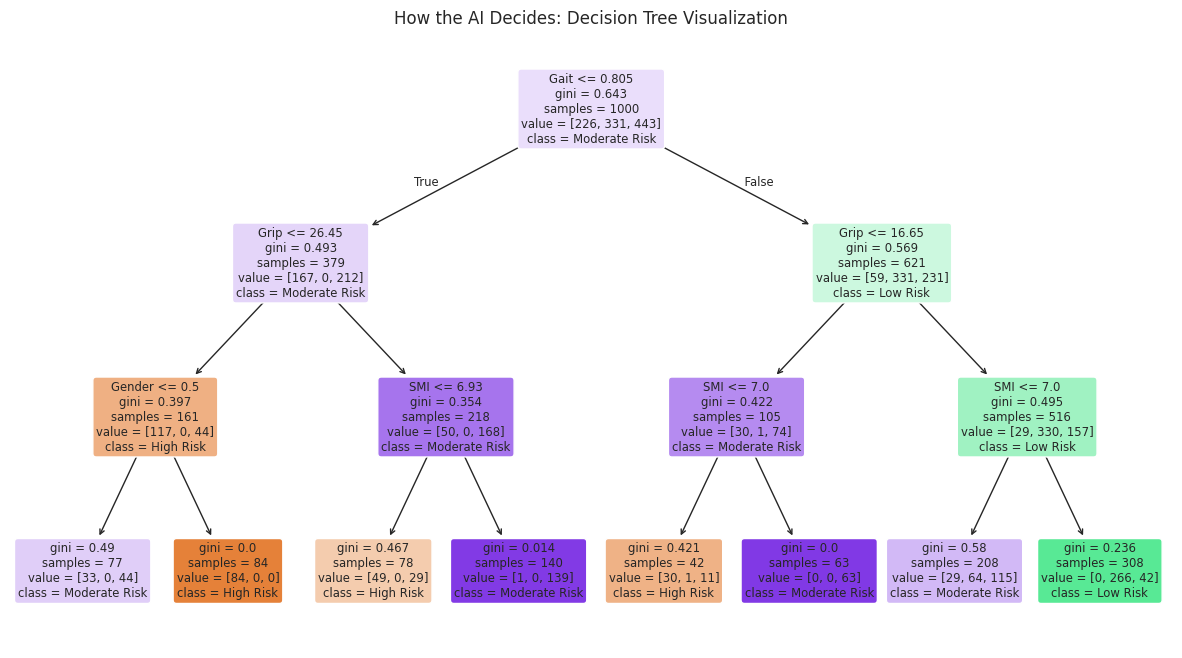

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 1. הכנת הדאטה למודל
# המודל צריך מספרים, אז נהפוך את המגדר (M/F) למספרים (0/1)
# ואת הדיאגנוזה למספרים (0=Low, 1=Moderate, 2=High)
df_ml = df.copy()
df_ml['Gender_Code'] = df_ml['Gender'].astype('category').cat.codes
df_ml['Diagnosis_Code'] = df_ml['Diagnosis'].astype('category').cat.codes

# המאפיינים (Features) שעל פיהם המודל יילמד
X = df_ml[['Age', 'Grip_Strength_KG', 'SMI', 'Gait_Speed_ms', 'Gender_Code']]
# התשובה הנכונה (Target) שהמודל מנסה לחזות
y = df_ml['Diagnosis_Code']

# 2. אימון המודל (Decision Tree)
# אנחנו בעצם "מאכילים" את המודל בנתונים שלנו
clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X, y)

# שינוי max_depth ל-None (ללא הגבלה)
clf_v3 = DecisionTreeClassifier(max_depth=None, random_state=42)

# אימון מחדש
clf_v3.fit(X_train, y_train)

# בדיקה מחדש
y_pred_unlimited = clf_v3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_unlimited)
print(f"Model Accuracy with UNLIMITED depth: {accuracy * 100:.2f}%")

# 3. ויזואליזציה של "המוח" של המודל
# נראה בדיוק איך המחשב קיבל את ההחלטות שלו
plt.figure(figsize=(15, 8))
plot_tree(clf, 
          feature_names=['Age', 'Grip', 'SMI', 'Gait', 'Gender'],  
          class_names=df_ml['Diagnosis'].astype('category').cat.categories,
          filled=True, 
          rounded=True)

plt.title("How the AI Decides: Decision Tree Visualization")
plt.show()

<Figure size 800x600 with 0 Axes>

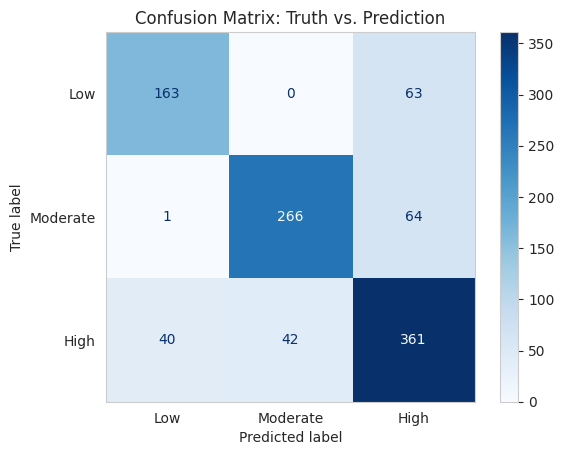

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. נבקש מהמודל לחזות את התוצאות מחדש על הדאטה שיש לנו
y_pred = clf.predict(X)

# 2. יצירת מטריצת הבלבול
# משווה בין התשובות האמיתיות (y) לבין מה שהמודל חזה (y_pred)
cm = confusion_matrix(y, y_pred)

# 3. ויזואליזציה
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Moderate', 'High'])
disp.plot(cmap='Blues', values_format='d')

plt.title('Confusion Matrix: Truth vs. Prediction')
plt.grid(False) # ביטול רשת הקווים כדי שיהיה נקי
plt.show()

In [27]:
from sklearn.metrics import accuracy_score

# 1. פיצול הדאטה: 80% לאימון, 20% למבחן
# random_state דואג שהערבוב יהיה קבוע בכל הרצה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. אימון המודל מחדש (רק על סט האימון!)
clf_v2 = DecisionTreeClassifier(max_depth=3, random_state=42)
clf_v2.fit(X_train, y_train)

# 3. מבחן האמת (חיזוי על סט המבחן שהמודל לא מכיר)
y_pred_test = clf_v2.predict(X_test)

# 4. בדיקת התוצאה
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Model Accuracy on NEW patients (Test Set): {accuracy * 100:.2f}%")

# הצגת ההשוואה
print("\nTrue Labels (Test):", y_test.values)
print("Predictions (AI):  ", y_pred_test)

Model Accuracy on NEW patients (Test Set): 78.00%

True Labels (Test): [0 1 1 0 2 2 2 2 2 0 1 2 0 0 2 1 2 2 0 1 2 1 2 1 2 1 2 0 0 2 0 1 1 2 2 0 2
 0 2 2 0 1 0 0 1 2 0 2 2 2 0 1 1 2 0 2 0 0 2 2 2 1 1 0 1 1 2 0 2 0 2 2 1 2
 2 1 2 0 0 1 0 1 1 2 2 0 1 2 2 1 2 0 1 2 2 2 1 1 0 2 0 2 1 1 1 2 2 2 1 2 1
 1 1 1 1 2 2 2 1 2 0 2 1 0 1 0 1 2 1 0 2 2 2 2 2 1 2 2 1 2 0 0 2 2 1 2 0 2
 1 1 0 1 1 2 2 1 2 0 0 2 2 2 1 1 2 2 1 0 1 0 2 0 1 1 0 0 2 1 0 0 1 2 1 2 2
 2 2 2 1 1 2 2 0 2 2 1 1 2 0 1]
Predictions (AI):   [2 1 2 0 2 2 2 2 2 0 1 2 2 0 2 1 2 2 0 1 2 1 2 1 2 1 2 0 0 2 0 2 2 2 2 0 2
 0 2 1 0 1 0 0 1 2 2 2 2 2 2 1 2 2 2 0 0 0 0 2 2 1 1 0 2 1 2 0 2 2 2 2 1 1
 2 1 2 2 0 1 0 1 1 2 2 0 2 1 0 1 2 0 1 2 2 1 1 1 0 2 2 2 1 1 1 2 2 2 1 2 2
 1 1 1 1 2 0 2 2 2 0 2 2 0 1 0 1 2 1 2 1 2 2 2 2 2 2 2 1 2 0 2 2 2 1 1 2 2
 2 1 2 1 1 2 2 1 2 0 0 2 2 2 2 1 2 2 2 2 1 0 2 2 2 1 0 0 0 0 2 0 1 2 1 2 2
 2 1 2 1 1 2 2 0 2 2 2 1 2 0 2]


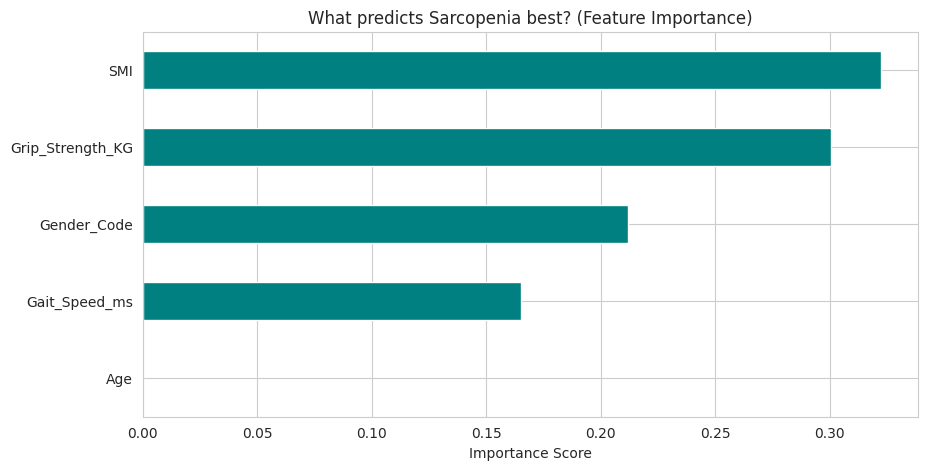

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# נשלוף את ציוני החשיבות מהמודל החזק (clf_v3)
importances = pd.Series(clf_v3.feature_importances_, index=X.columns)

# נמיין מהגבוה לנמוך ונציג בגרף
plt.figure(figsize=(10, 5))
importances.sort_values().plot(kind='barh', color='teal')

plt.title('What predicts Sarcopenia best? (Feature Importance)')
plt.xlabel('Importance Score')
plt.show()

In [30]:
import joblib

# 1. שמירת המודל לקובץ
# אנחנו שומרים את clf_v3 (המודל הכי טוב שלנו)
model_filename = 'sarcopenia_model.pkl'
joblib.dump(clf_v3, model_filename)

print(f"✅ Model saved successfully to '{model_filename}'")

# --- בדיקה שהשמירה עבדה ---

# 2. ננסה לטעון את המודל משמירה (כאילו אנחנו בשרת אחר עכשיו)
loaded_model = joblib.load(model_filename)

# 3. נבדוק אותו על מטופל חדש לדוגמה
# גיל 70, אחיזה 15 (חלש), מסה 6.0 (גבולי), הליכה 0.5 (איטי), גבר (0)
# לפי ההיגיון שלנו -> זה צריך להיות High Risk (קוד 2)
new_patient = [[70, 15.0, 6.0, 0.5, 1]] 

prediction = loaded_model.predict(new_patient)
diagnosis_map = {
    0: 'High Risk',      # H בא לפני L
    1: 'Low Risk',       # L בא לפני M
    2: 'Moderate Risk'   # M מגיע בסוף
}

# נבדוק שוב את התחזית שכבר קיבלנו (שהייתה 0)
print(f"Prediction Code: {prediction[0]}")
print(f"Diagnosis: {diagnosis_map[prediction[0]]}")

✅ Model saved successfully to 'sarcopenia_model.pkl'
Prediction Code: 0
Diagnosis: High Risk


/home/theitamarmizrahi/GitHub/bioinformatics project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
